Mount drive for file access

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


Import libraries

In [2]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.4 MB/s eta 0:00:00


In [3]:
!pip install import_ipynb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.6 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms, transforms
from torchvision.transforms import v2
import wandb
import import_ipynb

import os
from os import listdir
from os.path import isfile, join
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# For copying methods from other .ipynb files
!cp U-Net/Unet_torch.ipynb .
from Unet_torch import UNet, conv_block

importing Jupyter notebook from Unet_torch.ipynb


Check for compute device (cpu/gpu)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(
    project="unet_torch_rescaled",
    config={
        "epochs":25,
        "batch_size":6,
        "lr":1e-5,
        "activation":"ReLU",
        "num_output_ch": 2
    }
)

Define data directory

In [ ]:
data_dir = "U-Net/data"

Helper function to rescale images

In [7]:
def rescale(x, old_range, new_range, clamp=False,):
    old_min, old_max = old_range
    new_min, new_max = new_range
    x -= old_min
    x *= (new_max - new_min) / (old_max - old_min)
    x += new_min

    if clamp:
        x = x.clamp(new_min, new_max)
    return x

Create custom Pytorch Dataset for NII Images

In [ ]:
class NiiImagesDataset(Dataset):
  def __init__(self, root_dir):
    """
    Arguments:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.root_dir = root_dir
    self.img_files = [f for f in listdir(self.root_dir) if f.endswith("_img.png")]

  def __len__(self):
    return len(self.img_files)

  def __getitem__(self, idx):
    # return image file with num_img.png or num_msk.png as appropriate
    if (idx // 1e3 == 0):
      padded_idx = f"{idx:04}"
    else:
      padded_idx = f"{idx}"

    img_name = join(self.root_dir, f"{padded_idx}_img.png")
    mask_name = join(self.root_dir, f"{padded_idx}_msk.png")
    with Image.open(img_name) as image:
      image.load()
    with Image.open(mask_name) as mask:
      mask.load()
    # If saved as png, ensure image is read as RGB not RGBA
    torch_tf = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True)
        ])
    image = torch_tf(image.convert("RGB"))
    mask = torch_tf(mask.convert("P"))

    # rescale image from [0,1] to [-1,1]
    image = rescale(image, (0,1), (-1,1), clamp=True)
    if torch.max(mask).item() > 0:
      mask = rescale(mask, (0,torch.max(mask).item()), (0,1), clamp=True)

    #print(f"Image has shape {image.shape}.\nMask has shape {mask.shape}")

    return {"image": image, "mask": mask}

Implement dice loss - appears to give best segmentation results

In [ ]:
def dice_loss(
    input: torch.Tensor,
    target: torch.Tensor,
    multiclass: bool=True,
    epsilon: float=1e-6,
):
  if multiclass:
    input = input.flatten(0,1)
    target = target.flatten(0,1)

  sum_dim = (-1,-2,-3) if len(input.shape) == 3 else (-1,-2)
  inter = 2 * (input * target).sum(dim=sum_dim)
  sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
  sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

  dice = (inter + epsilon) / (sets_sum + epsilon)

  return 1-dice.mean()

In [ ]:
def evaluate_model_learning(
    model,
    device,
    val_dir,
):
  model.eval()
  # Test file: 98-142 -> total length is 45
  # if validation loss on combined 20 images does not change for 5 epochs -> decrease LR
  with torch.no_grad():
    val_loss = 0
    for index in range(98,143):
      if (index // 1e3 == 0):
        val_padded_index = f"{index:04}"
      else:
        val_padded_index = f"{index}"

      val_img_name = join(val_dir, f"{val_padded_index}_img.png")
      val_mask_name = join(val_dir, f"{val_padded_index}_msk.png")
      with Image.open(val_img_name) as val_image:
        val_image.load()
      with Image.open(val_mask_name) as val_mask:
        val_mask.load()
      # If saved as png, ensure image is read as RGB not RGBA
      torch_transform = v2.Compose([
          v2.ToImage(),
          v2.ToDtype(torch.float32, scale=True)
          ])
      val_image = torch_transform(val_image.convert("RGB"))
      val_image = torch.unsqueeze(val_image, 0).to(device=device)
      val_mask = torch_transform(val_mask.convert("P")).to(device=device, dtype=torch.long)
      # rescale image from [0,1] to [-1,1]
      val_image = rescale(val_image, (0,1), (-1,1), clamp=True)
      if torch.max(val_mask).item() > 0:
        val_mask = rescale(val_mask, (0,torch.max(val_mask).item()), (0,1), clamp=True)
      val_pred = model(val_image)
      val_pred = val_pred.to(device=device)
      val_loss += dice_loss(
          F.softmax(val_pred, dim=1).float(),
          F.one_hot(val_mask, model.num_classes).permute(0, 3, 1, 2).float(),
          multiclass=True
      )
      del val_image, val_mask, val_pred

  val_loss /= (143-98)
  model.train()
  return val_loss

Training model function

In [ ]:
def train_model(
    model,
    device,
    epochs: int = 5,
    batch_size: int = 4,
    lr: float = 1e-5,
    save_ckpt: bool = False,
):
  train_dir = NiiImagesDataset(join(data_dir, "train_monochromatic"))
  val_dir = join(data_dir, "test_monochromatic")

  train_loader = DataLoader(train_dir, shuffle=True, batch_size=batch_size)

  optimizer = optim.AdamW(params = model.parameters(), lr=lr)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)
  grad_scaler = torch.cuda.amp.GradScaler()
  criterion = nn.CrossEntropyLoss() if model.num_classes > 1 else nn.BCEWithLogitsLoss()

  for epoch in range(1, epochs+1):
    model.to(device=device)
    model.train()
    for idx, batch in enumerate(train_loader):
      img, msk = batch["image"], batch["mask"]

      # check img and msk are correct shapes
      #print(f"\nMinibatch of images has shape {img.shape}.\nMinibatch of msks has shape {msk.shape}\n")
      assert img.shape[2] == img.shape[3], \
        "Network expects image height and width dimensions to be equal, " \
        f"instead they were {img.shape[2]}x{img.shape[3]}."
      assert msk.shape[2] == msk.shape[3], \
        "Network expects msk height and width dimensions to be equal, " \
        f"instead they were {msk.shape[2]}x{msk.shape[3]}."
      assert img.shape[2] == 512, \
        "Network expects image dimensions of 512x512, " \
        f"instead they were {img.shape[2]}x{img.shape[3]}."
      assert msk.shape[2] == 512, \
        "Network expects msk dimensions of 512x512, " \
        f"instead they were {msk.shape[2]}x{msk.shape[3]}."

      # send images, msks to device if you want
      img = img.to(device=device)
      msk = msk.squeeze()
      # if last minibatch only has one image, throws error
      # ValueError: Expected input batch_size (1) to match target batch_size (512)
      if (msk.shape[0] == 512):
        msk = msk.unsqueeze(0)
      msk = msk.to(device=device, dtype=torch.long)
      with torch.autocast(device.type if device.type != "mps" else "cpu"):
        preds = model(img)
        preds = preds.to(device=device)
        if (model.num_classes > 1):
          loss = criterion(preds, msk)
          loss += dice_loss(
              F.softmax(preds, dim=1).float(),
              F.one_hot(msk, model.num_classes).permute(0, 3, 1, 2).float(),
              multiclass=True
          )
        else:
          loss = criterion(preds.squeeze(1), msk.float())
          loss += dice_loss(F.sigmoid(preds.squeeze(1)), msk.float(), multiclass=False)
      del img, msk, preds

      optimizer.zero_grad()
      grad_scaler.scale(loss).backward()
      grad_scaler.unscale_(optimizer)
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      grad_scaler.step(optimizer)
      grad_scaler.update()

      wandb.log({
        'train loss': loss.item(),
        'step': len(train_loader)*epoch+idx+1,
        'epoch': epoch
      })

    # include logic for plateauing learning rate
    val_loss = evaluate_model_learning(model, device, val_dir)
    scheduler.step(val_loss)
    wandb.log({
      'val loss': val_loss,
      'epoch': epoch
    })

    if epoch == epochs and save_ckpt:
      state_dict = model.state_dict()
      torch.save(state_dict, join(data_dir[:-4], "checkpoints", f"Unet_ckpt_epoch_{epoch}_grad_scaling_scheduler_step_monochromatic_2.pth"))


def main():
  # Initialize model for training
  model = UNet(in_channels=3, num_classes=2).to(device)
  # Define hyperparameters, if using .py, could use command-line args
  epochs = 20
  batch_size = 8 # remember 1408 training images in total
  lr = 1e-5
  # experiment results monitored through wandb
  train_model(model, device=device, epochs=epochs, batch_size=batch_size, lr=lr, save_ckpt=True)


if __name__ == "__main__":
  main()

In [ ]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,25
step,3068
train loss,0.44625
val loss,0.34752


Visualize images

In [ ]:
data_dir =  "U-Net/data"
ckpt_dir =  "U-Net/checkpoints"
preds_dir = "U-Net/predictions"

In [9]:
def pad_int(run_id, zfill=4):
  # pad id number to 4 digits
  return str(run_id).zfill(zfill)

def get_fname(fnumber, pred_bool, img_bool):
  fnum = pad_int(fnumber)
  if pred_bool:
    return f"{fnum}_pred.png"
  return f"{fnum}_img.png" if img_bool else f"{fnum}_msk.png"

Visualize U-Net prediction results

Train file 1: 168-225 (green/yellow)

Train file 2: 452-497, 526-574 (green/yellow)
(offset by 352)

Test file: 98-142, 172-227 (green/yellow)

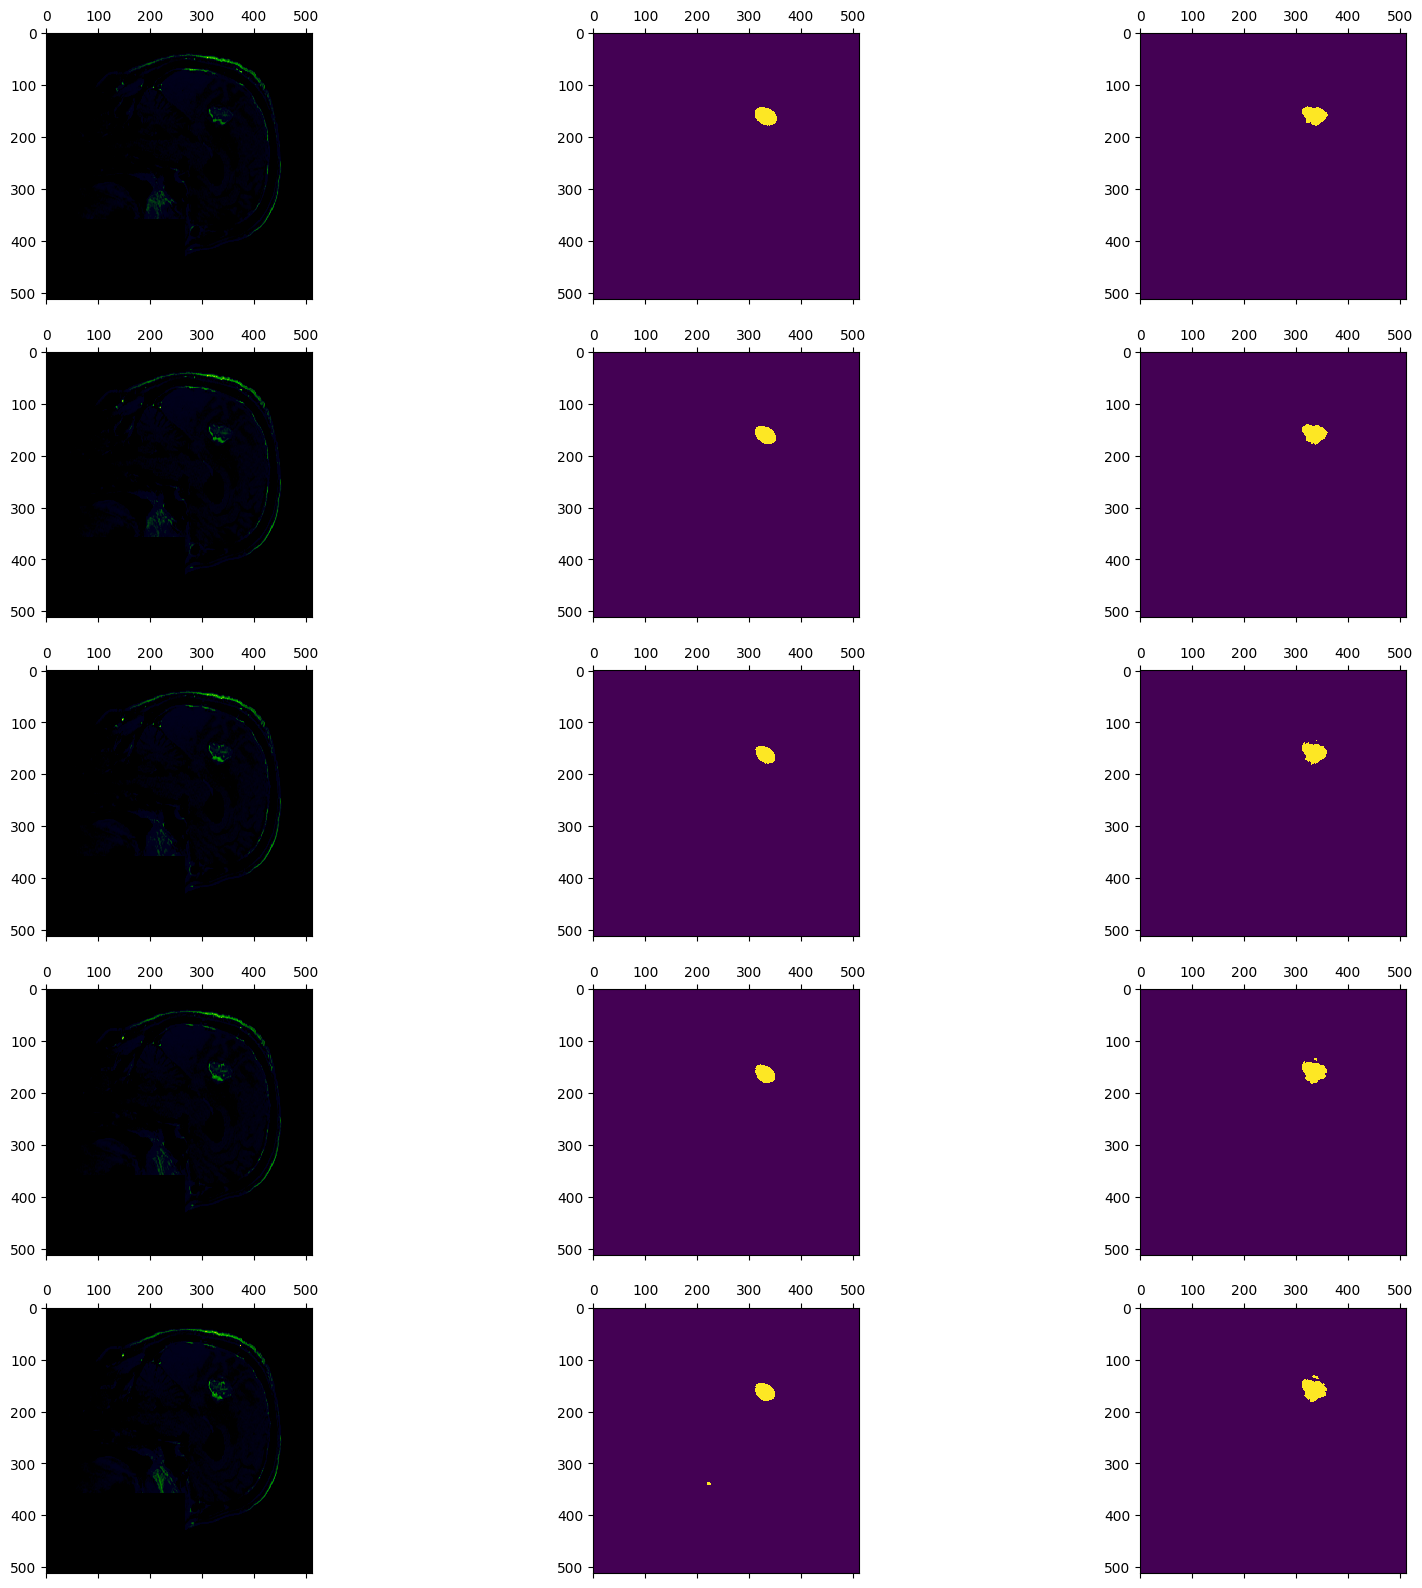

In [ ]:
# Keep 475-480 in mind for images that demonstrate little segmentation value on original image
# When rescaling to (-1,1), the expected input for the U-Net, little to any information can be seen

def visualize_model_results(
    model,
    device,
):
  model.eval()
  fig, ax = plt.subplots(5,3, figsize=(20, 20))

  for i in range(180, 185):
    img_name = get_fname(i, pred_bool=False, img_bool=True)
    mask_truth_name = get_fname(i, pred_bool=False, img_bool=False)

    with Image.open(join(data_dir, "train_monochromatic", img_name)) as image:
      image.load()
    with Image.open(join(data_dir, "train_monochromatic", mask_truth_name)) as mask_truth:
      mask_truth.load()

    torch_tf = v2.Compose([
      v2.ToImage(),
      v2.ToDtype(torch.float32, scale=True)
    ])

    image_copy = torch_tf(image.convert("RGB")).to(device=device)
    image = torch_tf(image.convert("RGB")).to(device=device)
    image = rescale(image, (0,1), (-1,1), clamp=True)
    mask_truth = torch_tf(mask_truth.convert("P"))

    mask_pred = model(image.unsqueeze(0))
    mask_pred = mask_pred.squeeze().detach().cpu()
    # get filename to save image
    mask_pred_name = get_fname(i, pred_bool=True, img_bool=False)
    mask = np.argmax(mask_pred, axis=0)

    #ax[i-180,0].matshow(image_copy.permute(1,2,0).squeeze().detach().cpu())
    ax[i-180,0].matshow(image.permute(1,2,0).squeeze().detach().cpu())
    ax[i-180,1].matshow(mask)
    ax[i-180,2].matshow(mask_truth.squeeze())

    #if (i > 122):
    #torchvision.utils.save_image(image_copy, join(preds_dir, f"val_{img_name}"))
    #torchvision.utils.save_image(image, join(preds_dir, f"val_{img_name}"))
    #plt.imsave(join(preds_dir, f"val_{mask_truth_name}"), mask_truth.squeeze())
    #plt.imsave(join(preds_dir, f"val_{mask_pred_name}"), mask)
    # visual inspection in gdrive between predicted and ground-truth

def main():
  # Initialize model for training
  model = UNet(in_channels=3, num_classes=2).to(device)
  # load in state dictionary values
  state_dict = torch.load(join(ckpt_dir, "Unet_ckpt_epoch_20_grad_scaling_scheduler_step_monochromatic_1.pth"), map_location=device)
  model.load_state_dict(state_dict)

  visualize_model_results(model, device=device)


if __name__ == "__main__":
  main()